In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

### **Load data**

In [3]:
#Reading user file:
u_cols =  ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./data/ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

n_users = users.shape[0]
print('Number of users:', n_users)
users.head() #uncomment this to see some few examples

Number of users: 943


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [4]:
#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

rate_train = pd.read_csv('./data/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
rate_test = pd.read_csv('./data/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')

# rate_train = ratings_base.as_matrix()
# rate_test = ratings_test.as_matrix()

print('Number of traing rates:', rate_train.shape[0])
print('Number of test rates:', rate_test.shape[0])

Number of traing rates: 90570
Number of test rates: 9430


In [5]:
print(rate_train.head())
print(rate_test.head())

   user_id  movie_id  rating  unix_timestamp
0        1         1       5       874965758
1        1         2       3       876893171
2        1         3       4       878542960
3        1         4       3       876893119
4        1         5       3       889751712
   user_id  movie_id  rating  unix_timestamp
0        1        20       4       887431883
1        1        33       4       878542699
2        1        61       4       878542420
3        1       117       3       874965739
4        1       155       2       878542201


(array([1]), [Text(1, 0, '1')])

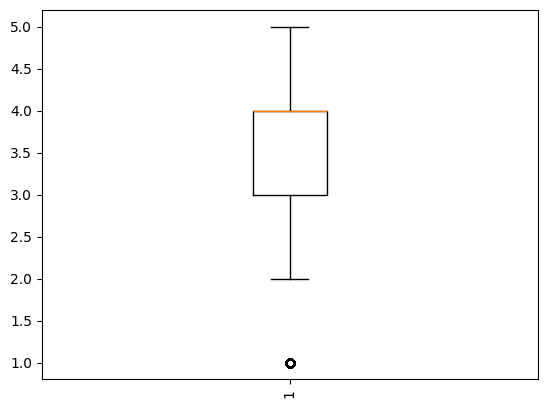

In [6]:
plt.boxplot(rate_train['rating'])
plt.xticks(rotation=90)

### **Establish item profiles**

In [7]:
#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 
        'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
        'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('./data/ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')

n_items = items.shape[0]
print('Number of items:', n_items)
items.head(3)

Number of items: 1682


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


* #### *Mark the genres that the films belongs*

In [8]:
item_counter = items.iloc[:,5:]
item_counter = TruncatedSVD(n_components=10).fit_transform(item_counter)
item_counter

array([[ 0.42815333,  0.98567456, -0.14101414, ..., -0.17343825,
        -0.46567848,  0.30970099],
       [ 0.34886382,  0.15849418,  1.52206757, ..., -0.22632823,
         0.233053  , -0.5823677 ],
       [ 0.14613918,  0.00221269,  0.57076853, ..., -0.1621657 ,
         0.0753382 , -0.08793653],
       ...,
       [ 1.09717346, -0.25839105, -0.17052655, ...,  0.03627062,
        -0.01636308, -0.01333857],
       [ 0.36359564,  0.86330643, -0.20130697, ..., -0.0298791 ,
         0.05317769, -0.02892787],
       [ 0.86674012, -0.44072189, -0.17427834, ..., -0.01020797,
         0.00702023, -0.02395807]])

* #### *Erect the TF-IDF matrix for the importance percentage of each word in a film*

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer

In [10]:
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(item_counter).toarray()
# tfidf = TruncatedSVD(n_components=7).fit_transform(tfidf)

In [11]:
print(tfidf.shape)
pd.DataFrame(tfidf)

(1682, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.270314,0.622305,-0.089029,-0.292043,0.100601,0.547172,0.016544,-0.109500,-0.294006,0.195529
1,0.203476,0.092442,0.887750,-0.073272,0.048161,0.054635,-0.001458,-0.132007,0.135929,-0.339668
2,0.148509,0.002249,0.580025,0.176663,-0.680926,0.286954,-0.152620,-0.164796,0.076560,-0.089363
3,0.796917,0.296145,0.163941,-0.274247,0.105781,-0.333186,0.015898,-0.152123,-0.170508,-0.021515
4,0.642389,-0.262401,0.295646,0.012297,-0.485331,0.157426,0.382311,0.135595,0.064258,0.043803
...,...,...,...,...,...,...,...,...,...,...
1677,0.867870,-0.441296,-0.174506,-0.132168,0.009077,-0.022736,-0.053011,-0.010221,0.007029,-0.023989
1678,0.268770,0.131714,0.410051,0.766359,-0.266757,0.256510,-0.082283,-0.082569,0.037082,-0.055183
1679,0.778236,-0.183279,-0.120956,0.544680,0.216603,0.038525,-0.012799,0.025727,-0.011606,-0.009461
1680,0.363731,0.863628,-0.201382,-0.202268,-0.160101,-0.099328,-0.017907,-0.029890,0.053197,-0.028939


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

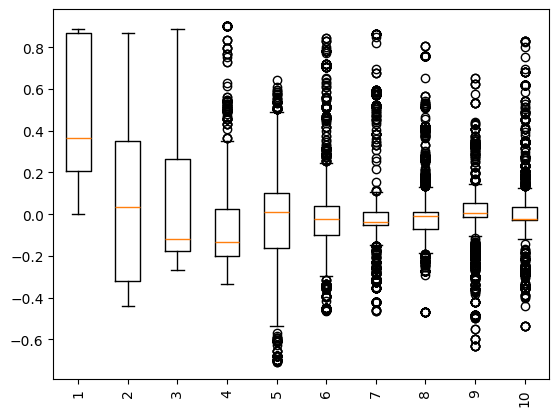

In [12]:
plt.boxplot(tfidf)
plt.xticks(rotation=90)

* #### *Remove TF-IDF outlier values*

In [13]:
tfidf_temp = pd.DataFrame(tfidf)
tfidf_temp = tfidf_temp[(tfidf_temp.loc[:, 4:10]<float(0.7)).all(axis=1)]

tfidf_temp

,0,1,2,3,4,5,6,7,8,9
0,0.270314,0.622305,-0.089029,-0.292043,0.100601,0.547172,0.016544,-0.109500,-0.294006,0.195529
1,0.203476,0.092442,0.887750,-0.073272,0.048161,0.054635,-0.001458,-0.132007,0.135929,-0.339668
2,0.148509,0.002249,0.580025,0.176663,-0.680926,0.286954,-0.152620,-0.164796,0.076560,-0.089363
3,0.796917,0.296145,0.163941,-0.274247,0.105781,-0.333186,0.015898,-0.152123,-0.170508,-0.021515
4,0.642389,-0.262401,0.295646,0.012297,-0.485331,0.157426,0.382311,0.135595,0.064258,0.043803
...,...,...,...,...,...,...,...,...,...,...
1677,0.867870,-0.441296,-0.174506,-0.132168,0.009077,-0.022736,-0.053011,-0.010221,0.007029,-0.023989
1678,0.268770,0.131714,0.410051,0.766359,-0.266757,0.256510,-0.082283,-0.082569,0.037082,-0.055183
1679,0.778236,-0.183279,-0.120956,0.544680,0.216603,0.038525,-0.012799,0.025727,-0.011606,-0.009461
1680,0.363731,0.863628,-0.201382,-0.202268,-0.160101,-0.099328,-0.017907,-0.029890,0.053197,-0.028939


### **Build the recommender model by using the predicted rating of users**

In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
class ContentBasedWithRating():
    def __init__(self, tfidf:TfidfTransformer) -> None:
        self.d = tfidf.shape[1]
        self.W = np.zeros((self.d, n_users))
        self.b = np.zeros((1, n_users))
        self.Yhat = None
    
    def get_items_rated_by_user(self, rate_matrix, user_id) -> tuple:
        """
        in each line of rate_matrix, we have infor: user_id, item_id, rating (scores), time_stamp
        we care about the first three values
        return (item_ids, scores) rated by user user_id
        """
        y = rate_matrix.iloc[:,0] # all users
        
        ids = np.where(y == user_id)[0] # users = user_id
        item_ids = rate_matrix.iloc[ids, 1] # movie_ids of user_id
        scores = rate_matrix.iloc[ids, 2] # rates of those movie_ids
        return item_ids, scores

    def fit_transform(self, rate_train:iter, n_users:int, learning_rate=0.01):
        for n in range(1, n_users+1):    
            ids, scores = self.get_items_rated_by_user(rate_train, n)   # choose the movie_ids and scores of rated movies by user_n
            
            clf = Ridge(alpha=learning_rate, fit_intercept = True)   # Predict rating of this user by the linear model + regularization
            Xhat = tfidf[ids-1, :]  # choose the feature vectors of movies were rated by user_n
            clf.fit(Xhat, scores)
            
            self.W[:, n-1] = clf.coef_
            self.b[0, n-1] = clf.intercept_
        
        # Predict the whole users' rating for each film which is Utility matrix
        self.Yhat = abs(tfidf.dot(self.W) + self.b)
            
    def predict(self, user_id:int, rate_test:iter, Yhat) -> tuple:      
        np.set_printoptions(precision=2) # 2 digits after . 
        movie_ids, scores = self.get_items_rated_by_user(rate_test, user_id)
        print('Rated movies ids :', movie_ids.to_list())
        print('True ratings     :', scores.to_list())
        print('Predicted ratings:', Yhat[movie_ids-1, user_id-1])
        # Plotting linear regression of rate_test and predicts
        sns.regplot(x=Yhat[movie_ids-1, user_id-1], y=scores)
        plt.xlabel('Predicted scores')
        plt.ylabel('Actual scores')
        
        return movie_ids.to_list(), Yhat[movie_ids-1, user_id-1]
    
    def AVG_MSE(self, rates:iter) -> float:
        mse_sum = 0.0
        for n in range(1, n_users+1):
            ids, scores_truth = self.get_items_rated_by_user(rates, n)
            scores_pred = self.Yhat[ids-1, n-1]
            mse = mean_squared_error(y_pred=scores_pred, y_true=scores_truth)
            mse_sum += mse
        
        return float(mse_sum)/len(rates)
    
def recommend(items, user_id, Yhat):
    return items['movie id'], Yhat[items['movie id']-1, user_id-1]

In [16]:
def search_lr(model, data, users, parameters):
    mse = []
    for learning_rate in parameters:
        model.fit_transform(data, users, learning_rate=learning_rate)
        
        mse.append(model.AVG_MSE(rate_test))
    
    print(mse)
    sns.lineplot(x=parameters, y=mse)
    

In [17]:
recommender = ContentBasedWithRating(tfidf=tfidf_temp)

[0.23278796896672121, 0.15667005783539042, 0.14713316665692483, 0.14203530585925753, 0.13858426503130405, 0.1280030777629772]


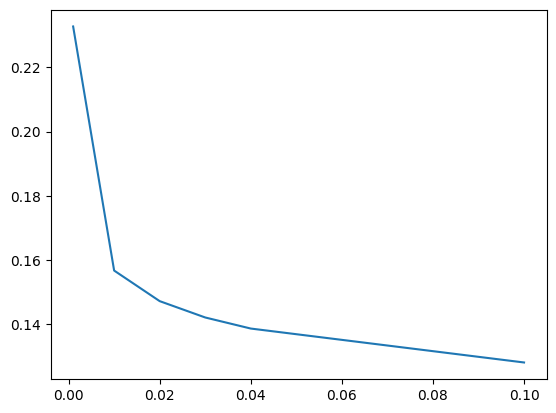

In [18]:
parameters = [0.001, 0.01, 0.02, 0.03, 0.04, 0.1]

search_lr(recommender, rate_train, n_users, parameters)

In [19]:
recommender.fit_transform(rate_train, n_users, learning_rate=0.1)

Testing prediction

Rated movies ids : [255, 257, 269, 289, 298, 301, 323, 412, 1047, 1160]
True ratings     : [4, 4, 3, 4, 3, 5, 1, 4, 1, 5]
Predicted ratings: [4.26 3.26 3.02 4.07 2.5  3.02 2.86 3.02 3.02 5.12]


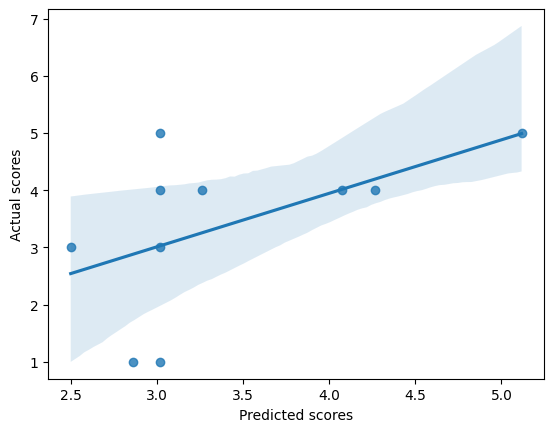

In [20]:
_, y_pred_test = recommender.predict(78, rate_test, recommender.Yhat)
_, y_true_test = recommender.get_items_rated_by_user(rate_test, 78)

In [21]:
print('R2 for testing', r2_score(y_pred=y_pred_test, y_true=y_true_test))
print('MSE for testing', mean_squared_error(y_pred=y_pred_test, y_true=y_true_test))

R2 for testing 0.27691856685359906
MSE for testing 1.3304698369893777


#### Evaluate the model

C:\Users\buidu\AppData\Local\Temp\ipykernel_14644\1508526776.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_true_test, hist=False, color='red', label='Actual value')


C:\Users\buidu\AppData\Local\Temp\ipykernel_14644\1508526776.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(y_pred_test, hist=False, color='blue', label='Predicted value', ax=ax1)


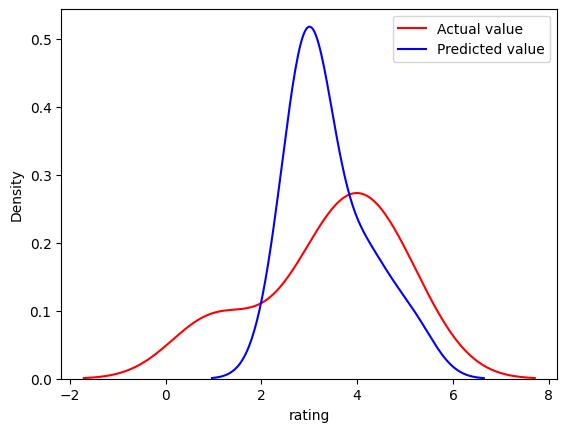

In [22]:
ax1 = sns.distplot(y_true_test, hist=False, color='red', label='Actual value')
ax2 = sns.distplot(y_pred_test, hist=False, color='blue', label='Predicted value', ax=ax1)
plt.legend()

In [23]:
print('MSE average for training:', recommender.AVG_MSE(rate_train))
print('MSE average for testing', recommender.AVG_MSE(rate_test))

MSE average for training: 0.007654252784410516
MSE average for testing 0.1280030777629772


### **Dump Yhat to csv file**

In [24]:
np.savetxt('./artificats/recommends.csv', recommender.Yhat, delimiter=',')

In [25]:
Yhat = np.loadtxt('./artificats/recommends.csv', delimiter=',')

In [26]:
print('Ma trận Utility giữa movie và user:', Yhat.shape)
Yhat

Ma trận Utility giữa movie và user: (1682, 943)


array([[2.46, 3.31, 1.13, ..., 5.05, 4.08, 2.7 ],
       [2.73, 4.65, 2.72, ..., 2.45, 4.4 , 3.62],
       [3.57, 2.96, 2.22, ..., 5.42, 4.12, 3.76],
       ...,
       [4.12, 4.09, 2.96, ..., 5.73, 4.63, 3.49],
       [3.59, 3.57, 3.21, ..., 3.81, 3.84, 2.73],
       [4.03, 3.67, 3.25, ..., 5.74, 4.46, 3.81]])

In [27]:
def recommend(items, user_id, Yhat):
    return Yhat[items['movie id']-1, user_id-1]

In [ ]:
# sorted(recommend(items, 1, Yhat).tolist(), reverse=True)